In [ ]:
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image_dataset_from_directory
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!rm -rf "/content/dataset_shortest"
!unzip -q "/content/drive/My Drive/dataset_shortest.zip" -d /content/
dataset_path = "/content/dataset_shortest"

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,  # Your dataset path
    shuffle=True,
    image_size=(128, 128),  # Resize the images to 128x128
    batch_size=16
)

Found 20146 files belonging to 2 classes.


In [ ]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    dataset_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [ ]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(128, 128),
    tf.keras.layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [ ]:



resnet_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
resnet_model.trainable = False

In [ ]:
model = tf.keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    resize_and_rescale,
    data_augmentation,
    resnet_model,
    layers.GlobalAveragePooling2D(),  # Pooling layer to reduce output size
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dense(2, activation='softmax')  # Output layer (for binary classification)
])

In [ ]:
from keras import mixed_precision

# Set mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Now compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:

EPOCHS = 50

history = model.fit(
        train_dataset,
        epochs=EPOCHS,  # Train for one epoch
        batch_size= 16,  # Use your batch size
        validation_data=val_dataset

    )




Epoch 1/50
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 91s 59ms/step - accuracy: 0.5533 - loss: 0.6784 - val_accuracy: 0.6022 - val_loss: 0.6621
Epoch 2/50
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 90s 31ms/step - accuracy: 0.6612 - loss: 0.6182 - val_accuracy: 0.7307 - val_loss: 0.5645
Epoch 3/50
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.6806 - loss: 0.6057 - val_accuracy: 0.6186 - val_loss: 0.6230
Epoch 4/50
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.6968 - loss: 0.5899 - val_accuracy: 0.7302 - val_loss: 0.5463
Epoch 5/50
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.7014 - loss: 0.5853 - val_accuracy: 0.7237 - val_loss: 0.5407
Epoch 6/50
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.7158 - loss: 0.5689 - val_accuracy: 0.7470 - val_loss: 0.5167
Epoch 7/50
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.7145 - loss: 0.5619 - val_accuracy: 0.7773 - val_loss: 0.5045
Epoch 8/50
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.7184 -

In [ ]:
scores = model.evaluate(test_dataset)
scores

126/126 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.7660 - loss: 0.4967


[0.4960191547870636, 0.7569444179534912]

In [ ]:
scoress = model.evaluate(train_dataset)
scoress

1008/1008 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.7627 - loss: 0.4896


[0.4873911440372467, 0.7626908421516418]

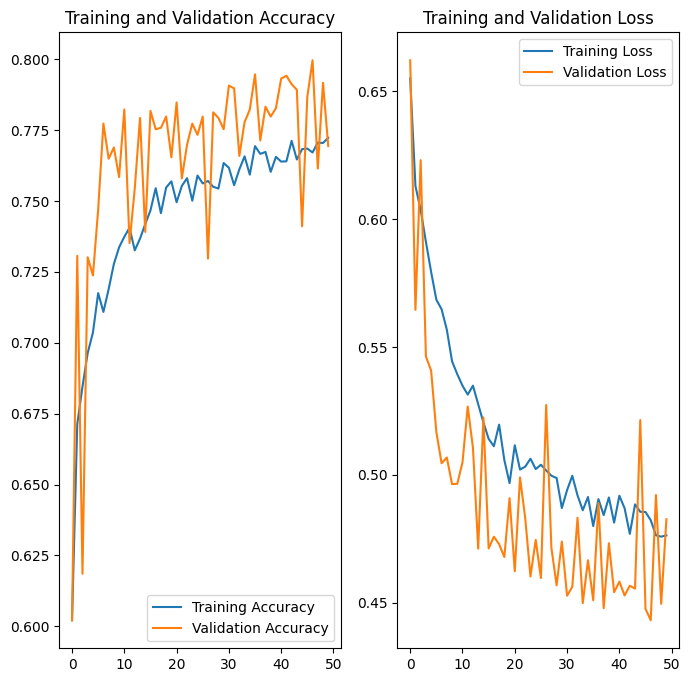

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Actual Label: Head_Movement_Allowed
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Label: Head_Movement_Allowed


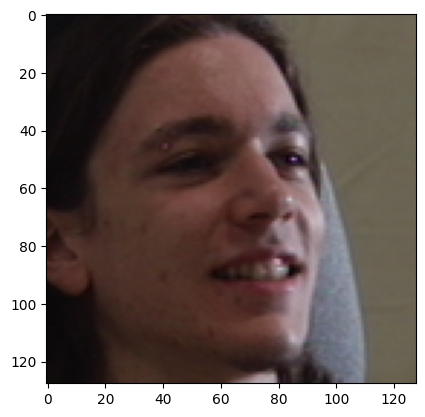

In [ ]:
for img, label in test_dataset.take(1):
    first_image = img[0].numpy().astype("uint8")
    first_label = label[0].numpy()

    plt.imshow(first_image, cmap='gray')
    print(f"Actual Label: {dataset.class_names[first_label]}")

    batch_prediction = model.predict(img)
    predicted_class = np.argmax(batch_prediction[0])
    print(f"Predicted Label: {dataset.class_names[predicted_class]}")

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

for img, label in test_dataset:
    preds = model.predict(img)
    y_true.extend(label.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.class_names, yticklabels=dataset.class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


In [ ]:
from PIL import Image, ImageOps
import numpy as np
import tensorflow as tf

def load_and_preprocess_image(img_path, target_size=(128, 128)):
    img = Image.open(img_path)  # Open the image using PIL
    img = ImageOps.fit(img, target_size, Image.Resampling.LANCZOS)  # Resize while keeping aspect ratio and adding padding
    return img

def predict_image(model, img_path):
    # Load and preprocess image
    img = load_and_preprocess_image(img_path, target_size=(128, 128))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    # img_array = img_array * (1.0 / 255.0)  # Normalize (if necessary)

    # Predict
    predictions = model.predict(img_array)
    predicted_class = dataset.class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence

# Example prediction on a single image
img_path = '/content/drive/MyDrive/Test pictures/A1.png'  # Replace with your image path
predicted_class, confidence = predict_image(model, img_path)
print(f"Predicted Class: {predicted_class}, Confidence: {confidence}%")

In [ ]:
model_version = 'CNN_Model2'
model.save(f"/content/drive/My Drive/{model_version}.keras")
print("Model saved successfully!")